# Exploratory data analysis for covid dataset

This notebook contains the combined EDA and cleaning process for analyzing the covid-19 case and death data for 2020.

## 0. imports

In [1]:
# configure settings
%reset -f
%config InlineBackend.figure_format = 'svg'


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from IPython.display import clear_output
import us
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm.notebook import tqdm

# custom packages
from covid_project.plotting_funcs import plot_counts_with_label
from covid_project.data_utils import load_covid_data, eval_df, check_data

BIG_TEXT   = 18
MED_TEXT   = 14
SMALL_TEXT = 10


## 1. Ingest data

In [2]:
path = "./data/covid_timeseries.csv"
# df = get_covid_data(path, force_reload=False)
df = load_covid_data(path, force_reload=False)
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22 00:00:00,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23 00:00:00,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24 00:00:00,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25 00:00:00,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26 00:00:00,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2. Exploration

## 2.1 Restrict to date range

Ensure that the data is for 2020 only - we are interested in how the spread of covid was affected by policies before the vaccine rollout

In [3]:
print("max date before filter: ", df['date'].max())
print("min date before filter: ", df['date'].min())

max_date = '2021-12-31'

df = df[df['date'] < max_date]

print("max date after filter: ", df['date'].max())
print("min date after filter: ", df['date'].min())

max date before filter:  2023-03-09 00:00:00
min date before filter:  2020-01-22 00:00:00
max date after filter:  2021-12-30 00:00:00
min date after filter:  2020-01-22 00:00:00




## 2.2 High-level observations

Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. df.info() gives similar information, however it's presented in terms on non-null datapoints and non-numeric datatypes seem to be cast to object. Use a custom-defined function to do something simular that counts the number of null values and lists all the datatypes present in each column

In [4]:
eval_df(df)

field                            num_nulls  datatypes
-----------------------------  -----------  --------------------------------
uid                                      0  {<class 'numpy.int64'>}
location_type                            0  {<class 'str'>}
fips_code                             7090  {<class 'numpy.float64'>}
location_name                         1418  {<class 'float'>, <class 'str'>}
state                                    0  {<class 'str'>}
date                                     0  {<class 'str'>}
total_population                     83662  {<class 'numpy.float64'>}
cumulative_cases                         0  {<class 'numpy.int64'>}
cumulative_cases_per_100_000         83662  {<class 'numpy.float64'>}
cumulative_deaths                        0  {<class 'numpy.int64'>}
cumulative_deaths_per_100_000        83662  {<class 'numpy.float64'>}
new_cases                             3338  {<class 'numpy.float64'>}
new_deaths                            3338  {<class 'numpy

Here we can see the first few issues with this dataset: 

1) some column names are particularly long, so we'll rename them

2) some columns contain null values
    
3) fips_code and total_population are expected to be integers

4) location_name should all be strings

begin by renaming certain columns

In [5]:
df.rename(columns={
    'cumulative_cases_per_100_000': 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000': 'cumulative_deaths_1e6',
    'new_cases_per_100_000': 'new_cases_1e6', 
    'new_deaths_per_100_000': 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg': 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg': 'new_deaths_7day'
    
}, inplace=True)

Based on the column names, we can infer what datatypes we're supposed to have:

Summary of columns and expected data types

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | positive integer
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Let's get a more visual description of how these nulls are distributed

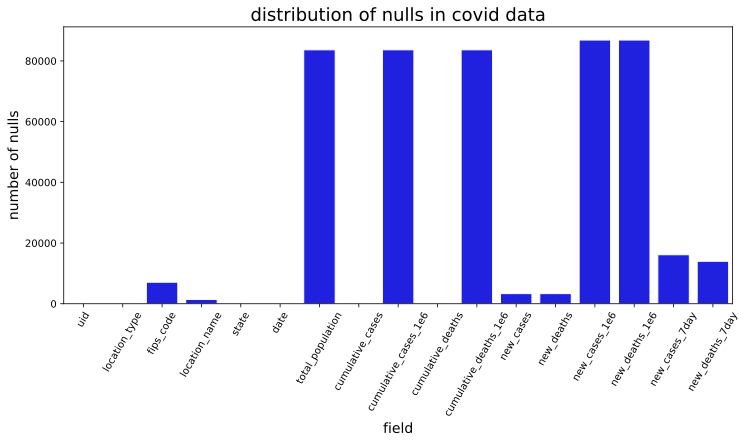

In [6]:
nulls = df.apply(lambda x: x.isnull().value_counts()).loc[True]

fig, ax = plt.subplots(figsize=[12, 5])
sns.set_style('darkgrid')
sns.barplot(x=nulls.index, y=nulls.values, ax=ax, color='b')
plt.xticks(rotation=60)
ax.set_ylabel("number of nulls", fontsize=MED_TEXT)
ax.set_xlabel("field", fontsize=MED_TEXT)
ax.set_title("distribution of nulls in covid data", fontsize=BIG_TEXT);

## 2.3 Column-by-column validation

#### 2.3.1 **uid**

In [7]:
check_data(df['uid'], "int", name='uid')

checking uid:
datatypes (expect int): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



#### 2.3.2 **location_type**


In [8]:
check_data(df['location_type'], "string", name="location_type", check_negs=False)

checking location_type:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



get a list of all the location types to see if we might want to throw anything out

In [9]:
loc_types = df['location_type'].unique()
print(loc_types)

['county' 'special_exception' 'out_of_state'
 'count_unassigned_to_location']


drop all records that don't have the location type of "county"

In [10]:
df = df.drop(df[~df['location_type'].isin(['county'])].index)
loc_types = df['location_type'].unique()
print(loc_types)

['county']


#### 2.3.3 **fips_code**

In [11]:
check_data(df['fips_code'], "int", name="fips_code")

checking fips_code:
datatypes (expect int): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



These appear to be stored as floats, but it seems unecessary since these codes are only supposed to be whole numbers. 

Are there any fractional fips codes in this set? If not we can cast the series to integers

In [12]:
check_data(df['fips_code'], check_ints=True)

all decimal components zero? (expect true) True


Convert all fips codes to integers

In [13]:
df['fips_code'] = df['fips_code'].astype(np.int64)
check_data(df['fips_code'], "int", check_types=True)

datatypes (expect int): {<class 'numpy.int64'>}


#### 2.3.4 **location_name**<br>

Since we're only dealing with counties, let's change 'location_name' to county

In [14]:
df.rename(columns={'location_name': 'county'}, inplace=True)
check_data(df['county'], "string", name="county", check_negs=False)

checking county:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Later in the project, we will want to examine the county-level distribution of nulls in some counties. To avoid mis-counting due to multiple counties with the same name (e.g. North Carolina and Virginia both have a Mecklenburg county) we can create a new column to concatenate county and state. 

In [15]:
df['full_loc_name'] = df['county'] + ', ' + df['state']
check_data(df['full_loc_name'], "string", name="full_loc_name", check_negs=False)

checking full_loc_name:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Convert all to lower case - this is to avoid any case mis-matches when referring to the county name in the case / death dataset and policy dataset. 

In [16]:
df['county'] = df['county'].str.lower()

#### 2.3.5 **state**

In [17]:
check_data(df['state'], "string", name="state", check_negs=False)

checking state:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



For this project, we're only considering the 50 states. Are there any territories in this set?

In [18]:
len(df['state'].unique())

52

In [19]:
df['state'].unique()

array(['Puerto Rico', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

Let's remove Puerto Rico and Washington DC

In [20]:
df.drop(df[df['state'].isin(['Puerto Rico', 'District of Columbia'])].index, inplace=True)
len(df['state'].unique())

50

#### 2.3.6 **date**

In [21]:
check_data(df['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'str'>}
number of nulls: 0



These dates are stored as strings instead of datetime objects, so lets convert them 

In [29]:
df['date'] = pd.to_datetime(df['date'].str[:10], format='%Y-%m-%d') # str[:10] is cutting off the time component since we don't care about it

In [30]:
check_data(df['date'], "datetime", check_types="True")

datatypes (expect datetime): {<class 'numpy.datetime64'>}


Check that we have the proper range of dates

In [41]:
min(df['date'])

Timestamp('2020-01-22 00:00:00')

In [42]:
max(df['date'])

Timestamp('2021-12-30 00:00:00')

#### 2.3.7 **total_population**

In [43]:
check_data(df['total_population'], "integer", name="total_population")

checking total_population:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



We seem to be missing the population counts for some counties

In [44]:
df[pd.isna(df['total_population'])].head()

,uid,location_type,fips_code,county,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name


In [45]:
df[pd.isna(df['total_population'])].groupby('county').count()

,uid,location_type,fips_code,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
county,,,,,,,,,,,,,,,,,


In [46]:
df[pd.isna(df['total_population'])].groupby('state').count()

,uid,location_type,fips_code,county,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
state,,,,,,,,,,,,,,,,,


We are missing population information for chugach and copper river (both counties in Alaska). Fill those in with a manual search

In [47]:
# https://data.statesmanjournal.com/census/total-population/total-population-change/chugach-census-area-alaska/050-02063/
df.loc[(df['county'] == 'chugach') & (df['state'] == 'Alaska'), 'total_population'] = 7102

# https://data.statesmanjournal.com/census/total-population/total-population-change/copper-river-census-area-alaska/050-02066/
df.loc[(df['county'] == 'copper river') & (df['state'] == 'Alaska'), 'total_population'] = 2617

In [48]:
check_data(df['total_population'], "integer", name="total_population")

checking total_population:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



It doesn't make sense for the total population to be a fractional number, so convert these to integers. So, we'll check that all the values are integers (i.e. end in .0) then convert

In [49]:
check_data(df['total_population'], check_ints=True)

all decimal components zero? (expect true) True


In [50]:
df['total_population'] = df['total_population'].astype(np.int64)
check_data(df['total_population'], "integer", check_types=True)

datatypes (expect integer): {<class 'numpy.int64'>}


#### 2.3.8 **cumulative_cases**

In [51]:
check_data(df['cumulative_cases'], "integer", name="cumulative_cases")

checking cumulative_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



#### 2.3.9 **cumulative_cases_1e6**

In [52]:
check_data(df['cumulative_cases_1e6'], "float", name="cumulative_cases_1e6")

checking cumulative_cases_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 1418
number of negative values: 0



#### 2.3.10 **cumulative_deaths**

In [53]:
check_data(df['cumulative_deaths'], "integer", name="cumulative_deaths")

checking cumulative_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



#### 2.3.11 **cumulative_deaths_1e6**

In [54]:
check_data(df['cumulative_deaths_1e6'], "float", name="cumulative_deaths_1e6")

checking cumulative_deaths_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 1418
number of negative values: 0



#### 2.3.12 **new_cases and new_deaths** 

For the sake of brevity, we'll look at new_cases and new_deaths at the same time

In [55]:
check_data(df['new_cases'], "integer", name="new_cases")
check_data(df['new_deaths'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3143
number of negative values: 26512

checking new_deaths:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3143
number of negative values: 7957



First of all, is there a particular pattern to where these NaNs and negative numbers are located? or does it appear in a mostly uniform distribution? 

In [56]:
num_states_case_negative    = len(df['state'][df['new_cases' ]   <0    ].unique())
num_states_death_negative   = len(df['state'][df['new_deaths']   <0    ].unique())
num_states_case_null        = len(df['state'][df['new_cases' ].isnull()].unique())
num_states_death_null       = len(df['state'][df['new_deaths'].isnull()].unique())

num_counties_case_negative  = len(df['full_loc_name'][df['new_cases' ]   <0    ].unique())
num_counties_death_negative = len(df['full_loc_name'][df['new_deaths']   <0    ].unique())
num_counties_case_null      = len(df['full_loc_name'][df['new_cases' ].isnull()].unique())
num_counties_death_null     = len(df['full_loc_name'][df['new_deaths'].isnull()].unique())

neg_county_case_ratio       = num_counties_case_negative  / len(df['full_loc_name'].unique())*100
neg_county_death_ratio      = num_counties_death_negative / len(df['full_loc_name'].unique())*100
null_county_case_ratio      = num_counties_case_null      / len(df['full_loc_name'].unique())*100
null_county_death_ratio     = num_counties_death_null     / len(df['full_loc_name'].unique())*100

arrays = [['negative', 'negative', 'null', 'null'], ['# states', '% counties', '# states', '% counties']]
tuples = list(zip(*arrays))
cols = pd.MultiIndex.from_tuples(tuples, names=['type', 'level'])

index = ['cases', 'deaths']

data = [
    [num_states_case_negative, neg_county_case_ratio, num_states_case_null, null_county_case_ratio],
    [num_states_death_negative, neg_county_death_ratio, num_states_death_null, null_county_death_ratio]
]

invalids = pd.DataFrame(data=data, index=index, columns=cols)
invalids

type   negative                null           
level  # states % counties # states % counties
cases        50  87.591473       50      100.0
deaths       50  63.156220       50      100.0

For both new cases and new deaths, most states have recorded a negative value and **all** counties have nulls. 

The explanation for the negative values we're seeing can be found in [this comment](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) on the dataset

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.


I'll analyze the distribution of negative values in the next section to see if there's any pattern associated with it. Save the dataset filtered to negative values for later

In [57]:
neg_cases  = df[df['new_cases' ]<0]
neg_deaths = df[df['new_deaths']<0]

neg_cases.to_csv("./data/neg_cases_timeseries.csv")
neg_deaths.to_csv("./data/neg_deaths_timeseries.csv")

On to the null values:

On what dates did these null values occur? 

In [58]:
dates_null_cases  = df['date'][df['new_cases'].isnull()].value_counts()
dates_null_deaths = df['date'][df['new_deaths'].isnull()].value_counts()

print(f"dates for new cases: \n{dates_null_cases}\n")
print(f"dates for new deaths: \n{dates_null_deaths}\n")

dates for new cases: 
date
2020-01-22    3143
Name: count, dtype: int64

dates for new deaths: 
date
2020-01-22    3143
Name: count, dtype: int64



Every instance of a null in new_cases and new_deaths occur on the first day that data was collected, so we can simply set those to zero

In [59]:
df.fillna(value={'new_cases': 0, 'new_deaths': 0}, inplace=True)

Finally, cast everything to integers- first checking that all new case numbers are whole numbers

In [60]:
print(f"new_cases: ")
check_data(df['new_cases'], check_ints=True)

print(f"\nnew_deaths: ")
check_data(df['new_deaths'], check_ints=True)

new_cases: 
all decimal components zero? (expect true) True

new_deaths: 
all decimal components zero? (expect true) True


In [61]:
df['new_cases'] = df['new_cases'].astype(np.int64)
df['new_deaths'] = df['new_deaths'].astype(np.int64)

check_data(df['new_cases'], "integer", name="new_cases")
check_data(df['new_deaths'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 26512

checking new_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 7957



#### 2.3.13 **new_cases_1e6, new_deaths_1e6**

In [62]:
check_data(df['new_cases_1e6' ], "float", name="new_cases" )
check_data(df['new_deaths_1e6'], "float", name="new_deaths")

checking new_cases:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 4559
number of negative values: 26510

checking new_deaths:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 4559
number of negative values: 7957



This set has the exact same number of nulls and negative values as new_cases and new_deaths, which makes sense since these are calculated fields based on new_cases and new_deaths. Therefore we can apply the exact same treatment.

In [63]:
df['new_cases_1e6' ].clip(  lower=0, inplace=True)
df['new_cases_1e6' ].fillna(value=0, inplace=True)
df['new_deaths_1e6'].clip(  lower=0, inplace=True)
df['new_deaths_1e6'].fillna(value=0, inplace=True)

check_data(df['new_cases_1e6' ], "float", name="new_cases" )
check_data(df['new_deaths_1e6'], "float", name="new_deaths")

checking new_cases:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



#### 2.3.14 **new_cases_7day & new_deaths_7day**



In [64]:
check_data(df['new_cases_7day' ], "integer", name="new_cases_7day")
check_data(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 13323
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 12608
number of negative values: 0



new_cases_7day and new_deaths_7day have many more nulls than the previous 4 columns. The most likely case is that the 7 day rolling averages are null in the first 6 days of data collection since there weren't enough values to calculate an average. 

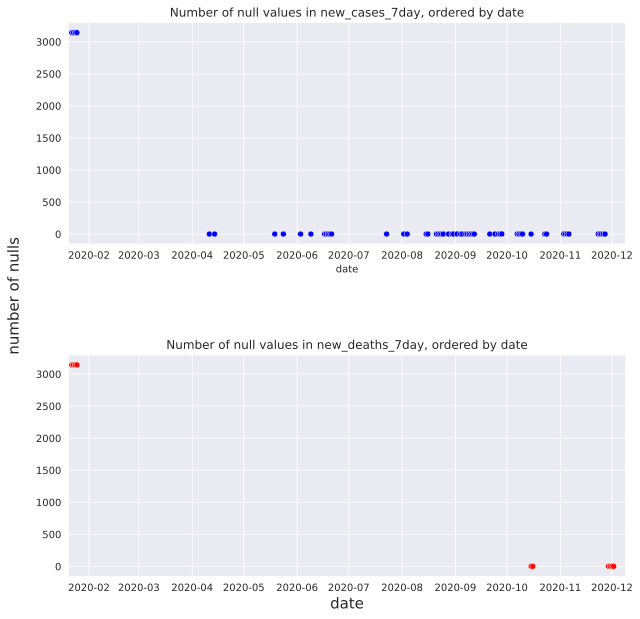

In [65]:
null_case_7day_counts=df['date'][df['new_cases_7day'].isnull()].value_counts().sort_index()
null_death_7day_counts=df['date'][df['new_deaths_7day'].isnull()].value_counts().sort_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)


sns.scatterplot(x=null_case_7day_counts.index, 
                y=null_case_7day_counts.values, 
                color='b', 
                ax=ax[0])
sns.scatterplot(x=null_death_7day_counts.index, 
                y=null_death_7day_counts.values,  
                color='r', 
                ax=ax[1])
ax[0].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.to_datetime('2020-12-09', format='%Y-%m-%d')])
ax[1].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.to_datetime('2020-12-09', format='%Y-%m-%d')])

ax[0].set_title("Number of null values in new_cases_7day, ordered by date")
ax[1].set_title("Number of null values in new_deaths_7day, ordered by date")





fig.text(0.04, 0.5, 'number of nulls', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

It looks like there are about 3000 nulls in the first few days, let's double check that that is the case


In [66]:
null_case_7day_counts.head()

date
2020-01-22    3143
2020-01-23    3143
2020-01-24    3143
2020-01-25    3143
2020-04-11       1
Name: count, dtype: int64

In [67]:
null_death_7day_counts.head()

date
2020-01-22    3143
2020-01-23    3143
2020-01-24    3143
2020-01-25    3143
2020-10-15       1
Name: count, dtype: int64

This matches exactly with the number of nulls in new_cases and new_deaths, so we're safe to set them to zero

In [68]:
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0))

In [69]:
check_data(df['new_cases_7day' ], "integer", name="new_cases_7day" )
check_data(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 751
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 36
number of negative values: 0



There are still some nulls present in the dataset. 

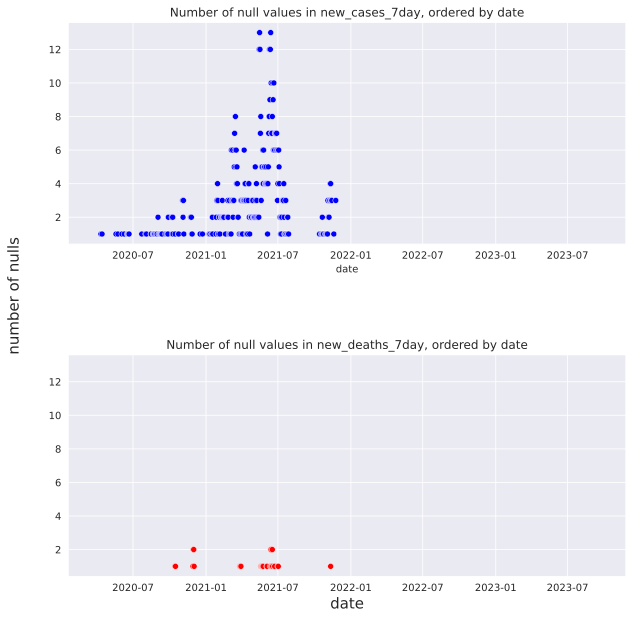

In [70]:
null_case_7day_counts=df['date'][df['new_cases_7day'].isnull()].value_counts().sort_index()
null_death_7day_counts=df['date'][df['new_deaths_7day'].isnull()].value_counts().sort_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)


sns.scatterplot(x=null_case_7day_counts.index, 
                y=null_case_7day_counts.values, 
                color='b', 
                ax=ax[0])
sns.scatterplot(x=null_death_7day_counts.index, 
                y=null_death_7day_counts.values,  
                color='r', 
                ax=ax[1])
ax[0].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.Timestamp.today()])
ax[1].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.Timestamp.today()])

ax[0].set_title("Number of null values in new_cases_7day, ordered by date")
ax[1].set_title("Number of null values in new_deaths_7day, ordered by date")





fig.text(0.04, 0.5, 'number of nulls', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

In [71]:
df['full_loc_name'][df['new_cases_7day'].isnull()].value_counts()

full_loc_name
Richmond, Virginia           39
Petersburg, Virginia         23
La Salle, Texas              16
Shenandoah, Virginia         15
Jones, Texas                 14
                             ..
Lancaster, South Carolina     1
Logan, Kentucky               1
Elliott, Kentucky             1
Monroe, Iowa                  1
Pierce, Nebraska              1
Name: count, Length: 182, dtype: int64

Since there are still some nulls in these series, let's re-calculate the 7 day rolling average at these dates

In [72]:
nulls_case7day  = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]
days_7   = timedelta(days=7)

i        = 0
num_elem = len(nulls_case7day)

msg      = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

for index, data in tqdm(nulls_case7day.iterrows(), desc="re calculating rolling averages for cases"):
    # i+=1
    # if i%10==0: 
    #     print(f"index: {i}/{num_elem}")
    # if i%250==0: 
    #     clear_output()
    #     print(msg)
    #     print(f"index: {i}/{num_elem}")
        
    df.loc[index, ['new_cases_7day']] = np.sum(([df['new_cases'][
        (df['full_loc_name']==data.full_loc_name) & 
        ((df['date']<=data.date) & (df['date']>data.date-days_7))
    ].values]))/7

i        = 0
num_elem = len(nulls_death7day)

for index, data in tqdm(nulls_death7day.iterrows(), desc='re-calculating rolling averages for deaths'):
   # i+=1
    # if i%10==0: 
    #     print(f"index: {i}/{num_elem}")
        
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name']==data.full_loc_name) & 
        ((df['date']<=data.date) & (df['date']>data.date-days_7))
    ].values]))/7


Looping through nulls in new_cases_7day. Please be patient, this may take a while


re calculating rolling averages for cases: 0it [00:00, ?it/s]

re-calculating rolling averages for deaths: 0it [00:00, ?it/s]

In [73]:
check_data(df['new_cases_7day' ], "integer", name="new_cases_7day" )
check_data(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 575

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 34



**new_cases_7day_1e6 & new_deaths_7day_1e6**

Create a new calculated field with the normalized 7 day running averages

In [74]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population']/1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population']/1e5)

check_data(df['new_cases_7day_1e6' ], "float", name="new_cases_7day_1e6" )
check_data(df['new_deaths_7day_1e6'], "float", name="new_deaths_7day_1e6")

checking new_cases_7day_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 575

checking new_deaths_7day_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 34



In [75]:
df.to_csv("./data/covid_timeseries_cleaned.csv")

## 2.4 Investigate the negative values in case / death numbers

Just out of curiosity, let's see if we can find any patterns in the occurences of negative values in the case / death numbers

In [76]:
neg_cases = pd.read_csv("./data/neg_cases_timeseries.csv", index_col=0)
neg_deaths = pd.read_csv("./data/neg_deaths_timeseries.csv", index_col=0)

neg_cases['date'] = pd.to_datetime(neg_cases['date'], format='%Y-%m-%d')
neg_deaths['date'] = pd.to_datetime(neg_deaths['date'], format='%Y-%m-%d')

In [77]:
neg_cases.head()

,uid,location_type,fips_code,county,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
93009,84001003,county,1003,baldwin,Alabama,2021-03-23,208107,20354,9780.55,297,142.72,-7.0,1.0,-3.36,0.48,22.33,0.43,"Baldwin, Alabama"
93019,84001003,county,1003,baldwin,Alabama,2021-04-02,208107,20519,9859.83,301,144.64,-4.0,0.0,-1.92,0.00,16.67,0.00,"Baldwin, Alabama"
94118,84001005,county,1005,barbour,Alabama,2021-02-17,25782,2053,7962.92,49,190.06,-2.0,1.0,-7.76,3.88,5.17,0.43,"Barbour, Alabama"
94135,84001005,county,1005,barbour,Alabama,2021-03-06,25782,2138,8292.61,51,197.81,-1.0,0.0,-3.88,0.00,4.20,0.00,"Barbour, Alabama"
94225,84001005,county,1005,barbour,Alabama,2021-06-04,25782,2342,9083.86,59,228.84,-1.0,0.0,-3.88,0.00,1.50,0.00,"Barbour, Alabama"


In [78]:
neg_deaths.head()

,uid,location_type,fips_code,county,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
91529,84001001,county,1001,autauga,Alabama,2020-04-20,55200,28,50.72,1,1.81,2.0,-1.0,3.62,-1.81,1.29,0.17,"Autauga, Alabama"
91540,84001001,county,1001,autauga,Alabama,2020-05-01,55200,43,77.90,3,5.43,1.0,-1.0,1.81,-1.81,1.00,0.33,"Autauga, Alabama"
91559,84001001,county,1001,autauga,Alabama,2020-05-20,55200,135,244.57,3,5.43,5.0,-1.0,9.06,-1.81,6.43,0.00,"Autauga, Alabama"
91694,84001001,county,1001,autauga,Alabama,2020-10-02,55200,1812,3282.61,27,48.91,13.0,-1.0,23.55,-1.81,8.86,0.50,"Autauga, Alabama"
91729,84001001,county,1001,autauga,Alabama,2020-11-06,55200,2257,4088.77,30,54.35,13.0,-1.0,23.55,-1.81,14.71,0.00,"Autauga, Alabama"


How are the negative values distributed among the states? 

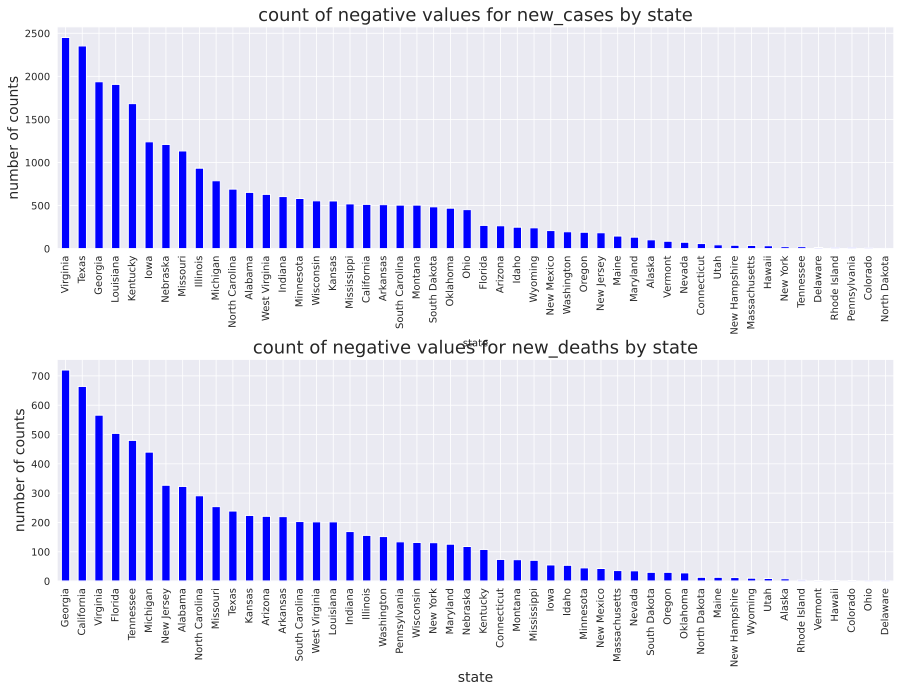

In [79]:
fig, ax = plt.subplots(nrows=2, figsize=[15,10])

plt.subplots_adjust(hspace=0.5)
neg_cases['state'].value_counts().plot.bar(ax=ax[0], color='b')
neg_deaths['state'].value_counts().plot.bar(ax=ax[1], color='b')

ax[0].set_title("count of negative values for new_cases by state", fontsize=BIG_TEXT)
ax[0].set_ylabel("number of counts", fontsize=MED_TEXT)

ax[1].set_title("count of negative values for new_deaths by state", fontsize=BIG_TEXT)
ax[1].set_xlabel("state", fontsize=MED_TEXT)
ax[1].set_ylabel("number of counts", fontsize=MED_TEXT);

There does not seem to be one state that is giving an overwhelmingly large contribution to the negative values for new_deaths, but it's clearly not uniformly distributed. This may be due to differences in reporting protocols where either some states are making more mistakes than others, or some states do not have robust protocols in place for catching errors.

How many negative values are present for any given day? Are there a few days that reported lots of negative values or are they evenly distributed?  

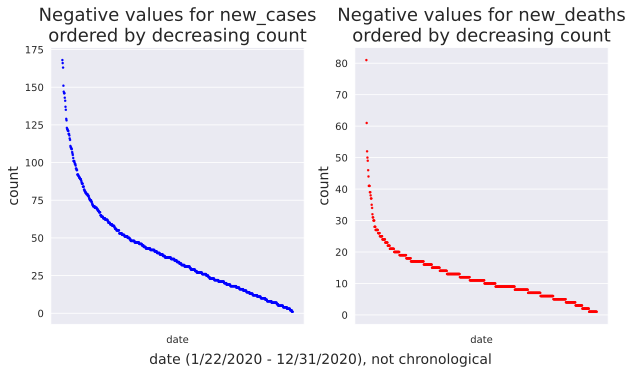

In [80]:
date_case_counts = neg_cases['date'].value_counts()
date_death_counts = neg_deaths['date'].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=[10,5])

sns.scatterplot(x=date_case_counts.index.strftime(date_format='%Y-%m-%d'), 
                y=date_case_counts, 
                ax=ax[0], 
                edgecolor=None, 
                s=5,
                color='b')


sns.scatterplot(x=date_death_counts.index.strftime(date_format='%Y-%m-%d'), 
                y=date_death_counts, 
                ax=ax[1], 
                edgecolor=None,
                s=5, 
                color='r')

ax[0].set_ylabel("count", fontsize=MED_TEXT)
ax[0].set(xticklabels=[])
ax[0].grid(axis='x')
ax[0].set_title("Negative values for new_cases\nordered by decreasing count", fontsize=BIG_TEXT)
ax[1].set_ylabel("count", fontsize=MED_TEXT)
ax[1].set(xticklabels=[])
ax[1].grid(axis='x')
ax[1].set_title("Negative values for new_deaths\nordered by decreasing count", fontsize=BIG_TEXT)
fig.text(0.5, 0, 'date (1/22/2020 - 12/31/2020), not chronological', ha='center', fontsize=MED_TEXT);

It appears that a few dates have many negative values (especially in new_deaths) while most dates have 20-40 negatives in new_cases and 5-20 negatives in new_deaths. 

How are these negatives distributed over time? 

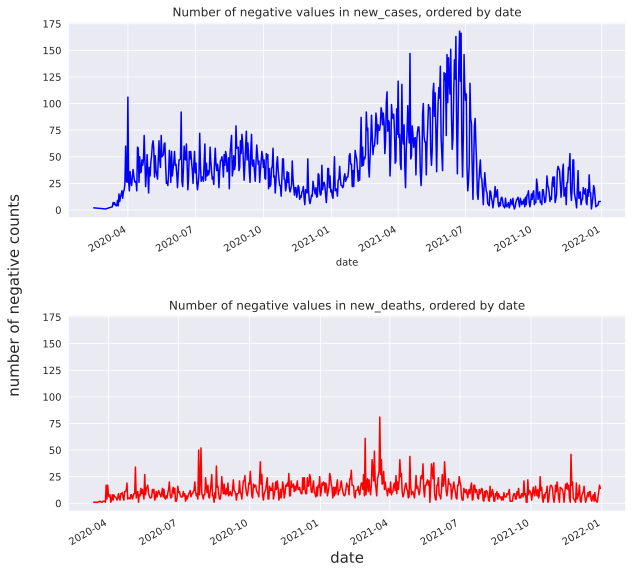

In [81]:
date_case_counts = neg_cases['date'].value_counts()
date_death_counts = neg_deaths['date'].value_counts()

fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)

date_case_counts.sort_index().plot.line(ax=ax[0], color='b')
date_death_counts.sort_index().plot.line(ax=ax[1], color='r')

ax[0].set_title("Number of negative values in new_cases, ordered by date")
ax[1].set_title("Number of negative values in new_deaths, ordered by date")


fig.text(0.04, 0.5, 'number of negative counts', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

These spikes in negative numbers appear to occur on a weekly basis. The number of negative values reported in new_cases has been graduallly decreasing since September.

negative values in new_deaths seem to peak in late September. Other than that, they seem to be relatively constant

What days of the week see the most negative values in new_deaths and new_cases? 

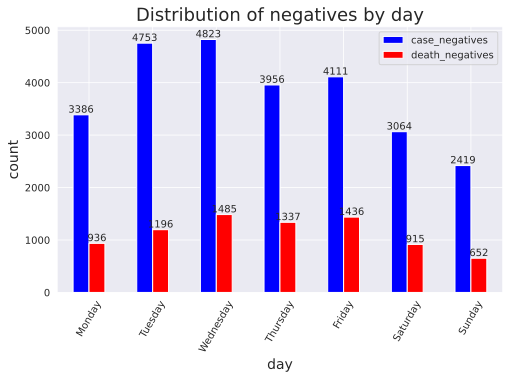

In [82]:
days = {
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday', 
    6: 'Sunday'
}
    
negative_data = {'day': [days[i] for i in range(0, 7)], 
                 'case_negatives': [sum(neg_cases['new_cases'][neg_cases['date'].dt.dayofweek==day].value_counts()) 
                                    for day in range(0, 7)],
                 'death_negatives': [sum(neg_deaths['new_deaths'][neg_deaths['date'].dt.dayofweek==day].value_counts()) 
                                    for day in range(0, 7)]}



negatives_by_day = pd.DataFrame(data=negative_data, columns=['case_negatives', 'death_negatives'], index=negative_data['day'])

fig, ax = plt.subplots(figsize=[8, 4.8])
negatives_by_day.plot.bar(ax=ax, color=['b', 'r'])
ax.set_title("Distribution of negatives by day", fontsize=BIG_TEXT)
ax.set_ylabel("count", fontsize=MED_TEXT)
ax.set_xlabel("day", fontsize=MED_TEXT)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),                             
               (p.get_x()+p.get_width()/2., p.get_height()),   
                fontsize=SMALL_TEXT,
                ha='center',                              
                va='center',                              
                xytext=(0, 5),                               
                textcoords='offset points')
plt.xticks(rotation=60);

Most negatives in new_cases appear on Tuesdays and most of the negatives on new deaths appear on Wednesdays, but not by a particularly large margin on cursory inspection. 

Now we examine the actual values. Are all these on the order of -1 or -2 or are there any larger values involved? 

In [83]:
case_values = neg_cases['new_cases'].value_counts()
death_values = neg_deaths['new_deaths'].value_counts()

print(f"value counts for invalid cases\n{case_values.head()}\n")
print(f"value counts for invalid deaths\n{death_values.head()}\n")

value counts for invalid cases
new_cases
-1.0    17285
-2.0     3723
-3.0     1503
-4.0      861
-5.0      550
Name: count, dtype: int64

value counts for invalid deaths
new_deaths
-1.0    6535
-2.0     723
-3.0     247
-4.0     140
-5.0      78
Name: count, dtype: int64



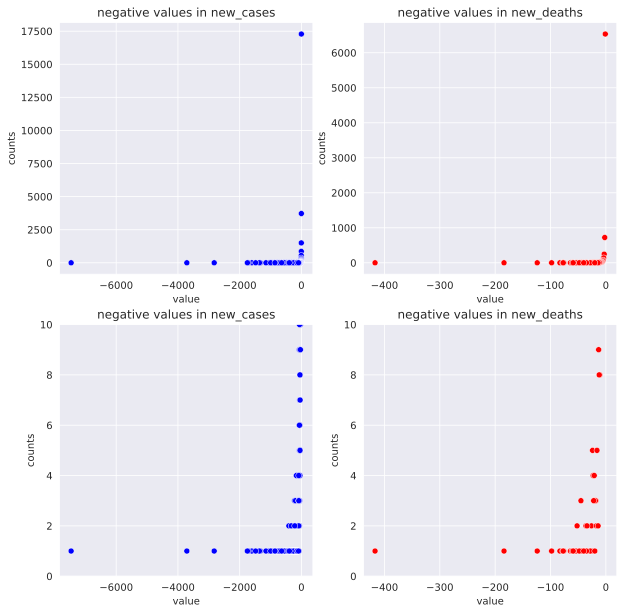

In [84]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=([10,10]))

for i in [0,1]:
    sns.scatterplot(x=neg_cases['new_cases'].value_counts().index, 
                    y=neg_cases['new_cases'].value_counts().values, 
                    color='b', 
                    ax=ax[i][0])
    sns.scatterplot(x=neg_deaths['new_deaths'].value_counts().index, 
                    y=neg_deaths['new_deaths'].value_counts().values, 
                    color='r', 
                    ax=ax[i][1])

    ax[i][0].set_title("negative values in new_cases")
    ax[i][0].set_ylabel("counts")
    ax[i][0].set_xlabel("value")
    ax[i][1].set_title("negative values in new_deaths")
    ax[i][1].set_ylabel("counts")
    ax[i][1].set_xlabel("value"); 
ax[1][0].set_ylim([0, 10]);
ax[1][1].set_ylim([0, 10]);

As expected, the vast majority are only at -1 or -2 for both new_cases and new_deaths. However, there are a few instances of particularly large negative values which have the potential to influence future modeling. 
 
For the sake of curiosity, let's look at which states and counties are the biggest culprits for these values. We're only interested in large negative values, which we'll call <-100 for cases and <-10 for deaths.  

Where are these large negative values occuring? 

In [85]:
neg_cases[['full_loc_name', 'date', 'new_cases']][neg_cases['new_cases']<-100].sort_values(by='new_cases').head(10)

,full_loc_name,date,new_cases
3012383,"Cameron, Texas",2021-08-22,-7460.0
350094,"San Joaquin, California",2020-12-23,-3711.0
2128726,"Essex, New Jersey",2021-04-26,-2825.0
513528,"Orange, Florida",2020-12-08,-1750.0
2134441,"Middlesex, New Jersey",2021-04-26,-1720.0
3046440,"Denton, Texas",2021-01-01,-1609.0
354854,"Santa Clara, California",2021-06-29,-1483.0
699808,"Union, Georgia",2020-11-09,-1361.0
2131012,"Hudson, New Jersey",2021-04-26,-1329.0
344403,"Sacramento, California",2021-01-16,-1149.0


In [86]:
neg_deaths[['full_loc_name', 'date', 'new_deaths']][neg_deaths['new_deaths']<-10].sort_values(by='new_deaths').head(10)

,full_loc_name,date,new_deaths
354896,"Santa Clara, California",2021-08-10,-417.0
3012406,"Cameron, Texas",2021-09-14,-184.0
352550,"San Mateo, California",2021-06-11,-124.0
3012157,"Cameron, Texas",2021-01-08,-98.0
1494111,"Middlesex, Massachusetts",2020-08-19,-83.0
339873,"Orange, California",2021-02-27,-78.0
3622719,"Milwaukee, Wisconsin",2021-07-27,-77.0
367091,"Tulare, California",2020-07-28,-76.0
1498683,"Suffolk, Massachusetts",2020-08-19,-64.0
1489539,"Essex, Massachusetts",2020-08-19,-61.0


From this, we see that Bexas County, Texas and Hudson County, New Jersey are responsible for the largest negative values.